In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

import re

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

In [4]:
cd


/Users/brianrochford


In [8]:
df = pd.read_excel('/Users/brianrochford/formatch.xlsx', index_col = 0)
df.countyGroup = df.countyGroup.replace(0, np.nan)
df = df.dropna().drop_duplicates()

In [9]:
Q1 = np.percentile(df['price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
df = df[df.price < (Q3+1.5*IQR)+1]

Q1 = np.percentile(df['points'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df['points'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
df = df[df.points < (Q3+1.5*IQR)+1]

In [10]:
data1 = pd.DataFrame(df.winery.value_counts())
data1.columns = ['counts'] 

data2 = df.groupby('winery').agg({'description':lambda x: ' '.join(x), 
                         'points':'mean', 
                         'price':'mean'})
df = data1.join(data2)

In [11]:
df

,counts,description,points,price
Testarossa,284,"Cooked cranberry is spiced with anise, pepperc...",90.781690,50.366197
Williams Selyem,278,"Smoky, with bursts of sage and celery root, th...",92.251799,55.661871
Chateau Ste. Michelle,268,This wine is aromatically reserved with notes ...,88.630597,22.511194
Columbia Crest,226,"The toast, freshly ground coffee, dark chocola...",87.765487,18.566372
Kendall-Jackson,190,"Clean and crisp, with rich flavors of citrus, ...",88.200000,23.257895
Gary Farrell,174,Masses of cherries and raspberries in this sin...,91.068966,48.166667
Kenwood,160,"Black as a moonless night, dense in structure,...",86.818750,22.737500
Robert Mondavi,156,"Pithy, with grapefruit and lemon peel flavors,...",87.544872,26.852564
De Loach,150,"Soft and appealing, this Pinot offers lush, el...",89.273333,35.620000
Cameron Hughes,150,Cameron Hughes bottles dozens of wines from Ca...,87.106667,18.306667


In [7]:
remove_non_alphabets = lambda x: re.sub(r'[^a-zA-Z]',' ',x)

tokenize = lambda x: word_tokenize(x)

ps = PorterStemmer()

stem = lambda w: [ ps.stem(x) for x in w ]

lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

remove_stop = lambda x: [w for w in x if w not in stop]

print('Processing : [=', end='')
df['description'] = df['description'].apply(remove_non_alphabets)
print('=', end='')
df['description'] = df['description'].apply(tokenize)
print('=', end='')
stop = text.ENGLISH_STOP_WORDS
df['description'] = df['description'].apply(remove_stop)
print('=', end='')
df['description'] = df['description'].apply(stem)
print('=', end='')
df['description'] = df['description'].apply(leammtizer)
print('=', end='')
df['description'] = df['description'].apply(lambda x: ' '.join(x))
print(']')

Processing : [======]


In [8]:
def get_sample(df,x):
    df = df.sample(frac=x, replace=False, random_state=1)
    df = df.reset_index(drop=True)
    return df

def tfidf_vector(df):
    
    tfidf_vectorizer=TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1),
                                     max_features=1000)
    
    tfidf_features = tfidf_vectorizer.fit_transform(df.description)  
    
    df_tfidf = pd.DataFrame(tfidf_features.toarray(),
                      columns=tfidf_vectorizer.get_feature_names())
    df_tfidf 
    
    return df_tfidf

def jointwo(df,df_tfidf):
    df = df.join(df_tfidf)
    df = df.drop(columns=['country','description'])
    df = df.fillna(0)
    return df

def run_random_for(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['points']), df.points, test_size=0.30, random_state=42)
    regr = RandomForestRegressor()
    regr.fit(X_train, y_train)
    return regr, X_test, y_test
    
def run_svr(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price']), df.price, test_size=0.30, random_state=42)
    regressor = SVR(kernel='rbf')
    regressor.fit(X_train,y_train)
    return regressor, X_test, y_test

In [9]:
df_tfidf = tfidf_vector(df.reset_index())

In [10]:
df_tfidf.rename(columns={'price':'pric'},inplace= True)

In [11]:
df_fin = df.reset_index().join(df_tfidf)

In [12]:
cols_to_norm = ['points','price']
df_fin[cols_to_norm] = df_fin[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [13]:
df_fin

,index,counts,description,points,price,abund,accent,access,accompani,acid,...,yet,yield,you,young,youth,zest,zesti,zin,zinfandel,zippi
0,Testarossa,363,cook cranberri spice ani peppercorn roast beef...,0.672521,0.634833,0.006493,0.009297,0.014407,0.005802,0.166559,...,0.028755,0.008936,0.015880,0.041315,0.015331,0.006522,0.019599,0.000000,0.000000,0.000000
1,Williams Selyem,355,smoki burst sage celeri root wine unabashedli ...,0.737148,0.681182,0.000000,0.024893,0.014837,0.005974,0.158739,...,0.036192,0.006135,0.019079,0.038495,0.007894,0.013432,0.006728,0.055988,0.057147,0.003350
2,DFJ Vinhos,333,thi crisp clean refresh wine there just lighte...,0.414039,0.090883,0.000000,0.002136,0.003310,0.000000,0.231739,...,0.000000,0.010265,0.000000,0.024860,0.002935,0.024973,0.005003,0.000000,0.000000,0.000000
3,Chateau Ste. Michelle,325,thi wine aromat reserv note milk chocol char b...,0.536538,0.255085,0.024531,0.042149,0.032658,0.007306,0.054717,...,0.000000,0.011253,0.003333,0.024776,0.009653,0.002738,0.000000,0.000000,0.000000,0.000000
4,Columbia Crest,296,the toast freshli ground coffe dark chocol che...,0.480152,0.195946,0.027849,0.047851,0.000000,0.004147,0.081346,...,0.000000,0.008517,0.015135,0.008438,0.007306,0.006216,0.003113,0.034545,0.012527,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17831,Maretima,1,thi sangioves outsid chianti doc drink like br...,0.687500,0.166667,0.000000,0.000000,0.000000,0.000000,0.090101,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283329
17832,Quinta da Pedra,1,a alvarinho small acr estat near mon o thi del...,0.562500,0.125000,0.000000,0.000000,0.000000,0.000000,0.131690,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17833,AJB Vineyards,1,bold power aroma white pepper blackberri explo...,0.625000,0.236111,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17834,Lopez Noceti,1,deep purpl color rich nose bacon roast berri r...,0.312500,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## ml

In [14]:
regr, x_test, y_test = run_random_for(df_fin.iloc[:,3:])

In [15]:
y_pred = regr.predict(x_test)
mean_squared_error(y_test, y_pred, squared=False)

0.09794115373329022

In [16]:
fet_imp = pd.DataFrame({"names":x_test.columns,
                       "importance":regr.feature_importances_})
best_features = list(fet_imp.sort_values(by=['importance'],ascending =False).names[:1000])

In [17]:
best_features

['price',
 'simpl',
 'ripe',
 'rich',
 'flavor',
 'drink',
 'tast',
 'soft',
 'beauti',
 'sweet',
 'concentr',
 'delici',
 'fruit',
 'wine',
 'miner',
 'black',
 'heavi',
 'bitter',
 'dri',
 'it',
 'the',
 'thi',
 'aroma',
 'eleg',
 'complex',
 'balanc',
 'fresh',
 'hard',
 'acid',
 'finish',
 'cherri',
 'like',
 'rustic',
 'fine',
 'tannin',
 'long',
 'candi',
 'palat',
 'smell',
 'bright',
 'vineyard',
 'spice',
 'great',
 'oak',
 'textur',
 'red',
 'good',
 'structur',
 'age',
 'feel',
 'littl',
 'year',
 'sour',
 'alcohol',
 'note',
 'bit',
 'blackberri',
 'veget',
 'juici',
 'sharp',
 'slightli',
 'green',
 'nose',
 'not',
 'plum',
 'linger',
 'offer',
 'firm',
 'lack',
 'show',
 'light',
 'sugari',
 'vanilla',
 'berri',
 'flat',
 'intens',
 'impress',
 'tart',
 'white',
 'dark',
 'just',
 'power',
 'fruiti',
 'blend',
 'hint',
 'bodi',
 'bare',
 'touch',
 'pure',
 'currant',
 'crisp',
 'winemak',
 'appl',
 'raspberri',
 'raisin',
 'hot',
 'doesn',
 'there',
 'herbal',
 'new',
 'c

### Sentiment Analysis (Vader)

In [18]:
## note I changed the name of the df below. we can always change it back to og df_fin
wine_sentiment_df = df_fin

In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
winescores = [analyzer.polarity_scores(sentence) for sentence in wine_sentiment_df['description']]

In [20]:
compound_s = [i["compound"] for i in winescores]
wine_sentiment_df['Compound_Wine_Score'] = compound_s

In [21]:
wine_sentiment_df['Sentiment_Type']=''
wine_sentiment_df.loc[wine_sentiment_df.Compound_Wine_Score>0,'Sentiment_Type']='POSITIVE'
wine_sentiment_df.loc[wine_sentiment_df.Compound_Wine_Score<=0,'Sentiment_Type']='NEGATIVE'

In [22]:
wine_sentiment_df[['description', 'points', 'price', 'Compound_Wine_Score','Sentiment_Type']]

,description,points,price,Compound_Wine_Score,Sentiment_Type
0,cook cranberri spice ani peppercorn roast beef...,0.672521,0.634833,1.0000,POSITIVE
1,smoki burst sage celeri root wine unabashedli ...,0.737148,0.681182,1.0000,POSITIVE
2,thi crisp clean refresh wine there just lighte...,0.414039,0.090883,1.0000,POSITIVE
3,thi wine aromat reserv note milk chocol char b...,0.536538,0.255085,1.0000,POSITIVE
4,the toast freshli ground coffe dark chocol che...,0.480152,0.195946,1.0000,POSITIVE
...,...,...,...,...,...
17831,thi sangioves outsid chianti doc drink like br...,0.687500,0.166667,0.5106,POSITIVE
17832,a alvarinho small acr estat near mon o thi del...,0.562500,0.125000,0.8519,POSITIVE
17833,bold power aroma white pepper blackberri explo...,0.625000,0.236111,0.8519,POSITIVE
17834,deep purpl color rich nose bacon roast berri r...,0.312500,0.111111,0.8316,POSITIVE


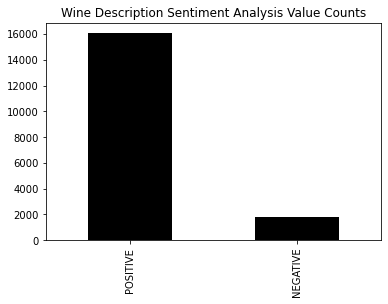

In [23]:
wine_sentiment_df.Sentiment_Type.value_counts().plot(kind='bar',color = 'black',title="Wine Description Sentiment Analysis Value Counts");

In [29]:
df_fin['Compunds'] = wine_sentiment_df.Compound_Wine_Score

In [31]:
df_fin = df_fin.drop(columns= ['Compound_Wine_Score','Sentiment_Type'])

In [40]:
df_fin.to_csv('groupedbywinerysentiment.csv')

In [32]:
regr, x_test, y_test = run_random_for(df_fin.iloc[:,3:])
y_pred = regr.predict(x_test)
mean_squared_error(y_test, y_pred, squared=False)

0.09849639348828296

In [33]:
fet_imp = pd.DataFrame({"names":x_test.columns,
                       "importance":regr.feature_importances_})
best_features = list(fet_imp.sort_values(by=['importance'],ascending =False).names[:1000])

In [34]:
best_features

['price',
 'Compunds',
 'simpl',
 'sweet',
 'flavor',
 'drink',
 'ripe',
 'soft',
 'tast',
 'delici',
 'fruit',
 'rich',
 'concentr',
 'wine',
 'beauti',
 'like',
 'black',
 'dri',
 'the',
 'thi',
 'aroma',
 'it',
 'complex',
 'acid',
 'long',
 'finish',
 'tannin',
 'miner',
 'balanc',
 'cherri',
 'rustic',
 'spice',
 'hard',
 'candi',
 'palat',
 'heavi',
 'age',
 'red',
 'oak',
 'structur',
 'eleg',
 'good',
 'fresh',
 'note',
 'vineyard',
 'sour',
 'year',
 'smell',
 'alcohol',
 'fine',
 'sharp',
 'great',
 'textur',
 'bit',
 'nose',
 'plum',
 'offer',
 'feel',
 'littl',
 'juici',
 'power',
 'green',
 'impress',
 'hint',
 'slightli',
 'blackberri',
 'bodi',
 'show',
 'berri',
 'light',
 'fruiti',
 'not',
 'bright',
 'currant',
 'firm',
 'bitter',
 'intens',
 'just',
 'veget',
 'blend',
 'dark',
 'mouth',
 'vanilla',
 'lack',
 'tart',
 'touch',
 'linger',
 'crisp',
 'raspberri',
 'pure',
 'hot',
 'there',
 'winemak',
 'lean',
 'charact',
 'mouthfeel',
 'jammi',
 'white',
 'sugari',
 '